<a href="https://colab.research.google.com/github/andrekuniyoshi/tera_mercado_financeiro/blob/main/notebooks/ProjetoTrader_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

**Projeto TERA - Mercado Financeiro**

* Neste notebook vamos realizar a EDA do ativo AAPL e fazer uma Feature Engineering também.

* Os dados foram coletados através de uma API do Yahoo Finance, e se encontram em pasta compartilhada. Eles também podem ser acessados no nosso GitHub

* Os principais pontos a serem analisados aqui serão: distribuição dos valores do ativo, sazonalidade, estacionaridade, comportamento de média móvel, identificação de outliers.

****
**Objetivos**
* Analisar o dataset, verificar se há padrões, dados faltantes, descartar dados não válidos

* Criar features de indicadores de compra e venda, que são consolidadas no mercado.

* Ter, ao final desse notebook, datasets prontos para serem utilizados em nossos diferentes modelos de predição

# Configurações do ambiente

#### install

In [94]:
!pip install pyyaml==5.4.1

# instalando lib que aplica indicadores traders
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
pip install statsmodels==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importando as libs

In [141]:
# importando do Google Drive
from google.colab import drive

# bibliotecas para tratamento dos dados
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# indicadores traders
from talib import RSI, BBANDS

In [97]:
# removendo os avisos
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Importando os Dados (gdrive)

Segundo a fonte dos dados (Yahoo Finance), as features apresentadas possuem os seguintes significados:

*   Open: primeiro preço da unidade de tempo avaliada (hora, dia...)
*   High: maior preço durante a unidade de tempo avalidada (hora, dia...)
*   Low: menor preço durante a unidade de tempo avalidada (hora, dia...)
*   Close: preço de fechamento segundo a unidade de tempo avaliada (hora, dia...)
*   Adj Close: preço ajustado depois de splits distribuição de dividendos. Os dados são ajustados segundo os padrões estabelecidos por Center for Research in Security Prices (CRSP).



Os dados já foram baixados e estão na pasta compartilhada com o grupo.

Assim, só precisamos importar os datasets de cada ativo diretamente do drive

In [98]:
# montando link com o drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [99]:
# importando o dataset da AAPL por hora
df_aapl_hora = pd.read_csv('/content/gdrive/My Drive/Tera - Grupo Mercado Financeiro/Dados/df_AAPL_hora.csv')
df_aapl_hora.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_aapl_hora['Date'] = pd.to_datetime(df_aapl_hora['Date'], utc=True)
df_aapl_hora.set_index('Date', inplace=True)

# conferindo o tamanho do dataset
print('AAPL hora tamanho:', df_aapl_hora.shape)

AAPL hora tamanho: (2273, 6)


# EDA (Análise exploratória de dados)

Agora que já importamos os dados, vamos fazer a análise exploratória do dataset.

Ao final, teremos três datasets prontos para serem utilizados nos modelos:
* df_arima: será utilizado para o ARIMA (Baseline)
* df_var_exog: para variáveis exógenas


HIPÓTESES

*   A série temporal possui sazonalidade
*   Série temporal não estacionária (média e desvio padrão não são constantes)
*   A série possui outliers





## Avaliando dataset 

In [100]:
# verificando informações gerais de AAPL
print('Dataset AAPL HORA\n')
print(df_aapl_hora.info())

Dataset AAPL HORA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2273 entries, 2021-01-04 14:30:00+00:00 to 2022-04-21 20:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2273 non-null   float64
 1   High       2273 non-null   float64
 2   Low        2273 non-null   float64
 3   Close      2273 non-null   float64
 4   Adj Close  2273 non-null   float64
 5   Volume     2273 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 124.3 KB
None


*   Não há dados faltantes nos datasets

In [101]:
# verificando as primeiras linhas dos datasets
df_aapl_hora.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04 14:30:00+00:00,133.520004,133.611603,130.380005,131.053604,131.053604,27653145
2021-01-04 15:30:00+00:00,131.054993,131.309998,129.399994,129.895004,129.895004,20134055
2021-01-04 16:30:00+00:00,129.889893,130.089996,126.760002,128.250000,128.250000,23694210
2021-01-04 17:30:00+00:00,128.246902,129.110001,127.630096,129.039795,129.039795,14745063
2021-01-04 18:30:00+00:00,129.039993,129.199997,128.595001,128.960007,128.960007,10861778


## Plot do dataset

*   Para evitar dados errôneos devido a splits e distribuição de dividendos, vamos utilizar a feature Adj Close, que já considera essas questões

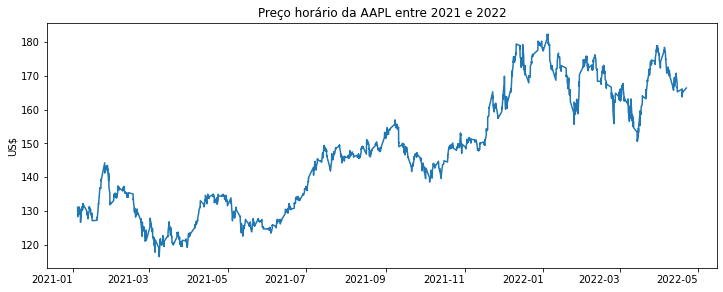

In [102]:
# plotando a variação de preço do ativo por hora
ax = df_aapl_hora['Adj Close'].plot(figsize=(12,5))
plt.title('Preço horário da AAPL entre 2021 e 2022')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição dos PREÇOS de AAPL HORA')

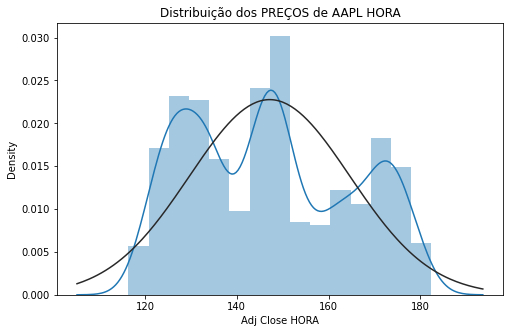

In [103]:
# plotando as distribuições dos preços, por DIA E HORA

plt.figure(figsize=(8,5))
ax = sns.distplot(df_aapl_hora['Adj Close'],
                   fit=norm,
                   kde=True)
ax.set_xlabel('Adj Close HORA')
ax.set_title('Distribuição dos PREÇOS de AAPL HORA')

*   Pelo plot de variação do preço por hora, podemos perceber que a série não parece estacionária, o que era esperado, por ser um ativo.

## EDA para ARIMA

A partir deste ponto, vamos focar a EDA para os pontos cruciais do modelo ARIMA

### Sazonalidade

*   Agora, vamos analisar se há sazonalidade do ativo. Para isso, precisamos agrupar a série em valores em certa periodicidade. Assim, vamos setar em 40, correspondente a 1 semana

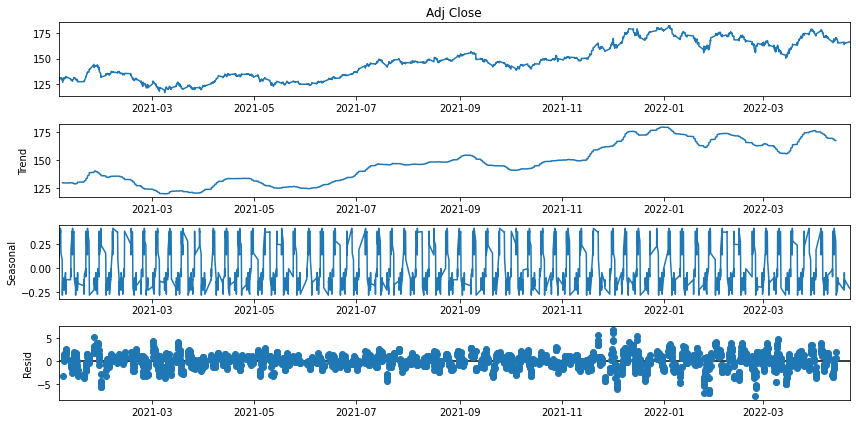

In [104]:
# fazendo a decomposição mensal
decomposicao_aapl = seasonal_decompose(df_aapl_hora['Adj Close'],
                                       model='additive', period = 40)
fig = decomposicao_aapl.plot()
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

* Nota-se, pelo gráfico acima, que há componente de sazonalidade na nossa série temporal.
* O resíduo fica maior no final do período analisado

### Série Estacionaria?

Agora, vamos analisar se a **série é estacionária, ou não**. Para que seja, ela precisa ter a média e a variância constantes no tempo, além de ter correlação entre 2 períodos constante
*   Vamos utilizar o **teste de Dickey Fuller** para verificar se nossa série é estacionária ou não.
*   **H0 -> Série não estacionária (p-value > 0.05)**
*   **H1 -> Série estacionária (p-value <= 0.05)**

In [105]:
# rodando o método de Dickey Fuller

adfuller_aapl_hora = adfuller(df_aapl_hora['Adj Close'])
print('ADF Statistics AAPL HORA:', adfuller_aapl_hora[0])
print('p-value AAPL HORA:', adfuller_aapl_hora[1])

ADF Statistics AAPL HORA: -1.2372893665712357
p-value AAPL HORA: 0.6573526804673867




* o resultado estatístico mostrou que **a série não é estacionária**. (p-value > 0.05)
* Então, vamos utilizar a técnica de diferenciação para tornar a série estacionária, para podermos aplicar o modelo ARIMA



#### Diferenciação do dataset

In [106]:
# Calculo do retorno percentual (1º diferenciação)
df_arima = df_aapl_hora.copy()
df_arima['return_percent'] = df_arima['Adj Close'].pct_change()
df_arima.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição dos retornos (1º Diferenciação)')

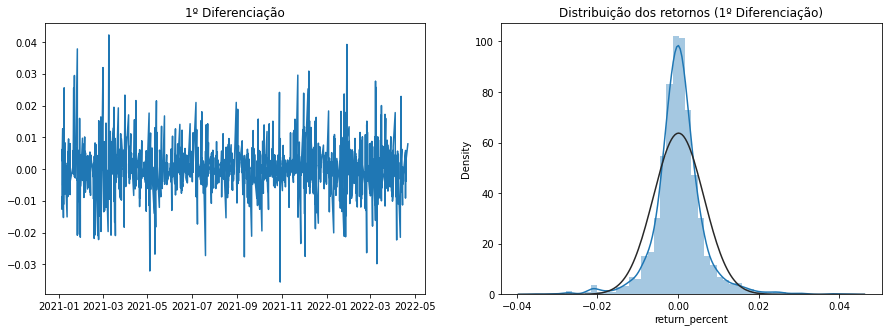

In [107]:
# verificando as distribuições dos retornos por HORA
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(df_arima['return_percent'])
axs[0].set_title('1º Diferenciação')

ax2 = sns.distplot(df_arima['return_percent'],
                   fit=norm,
                   kde=True,
                   ax=axs[1])
ax2.set_title('Distribuição dos retornos (1º Diferenciação)')

Text(0.5, 1.0, 'Distribuição da amostra comparado com teórico')

<Figure size 576x288 with 0 Axes>

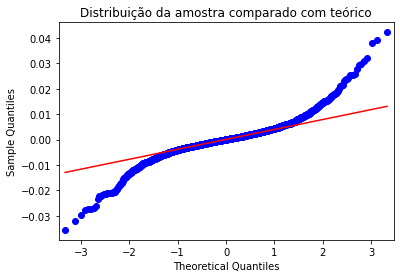

In [108]:
# comparando probabilidades de distribuições
# entre teórico e a amostra
plt.figure(figsize=(8,4))
qq1 = sm.qqplot(df_arima['return_percent'],
                line = 'q')
plt.title('Distribuição da amostra comparado com teórico')

In [109]:
# rodando o método de Dickey Fuller para retorno PERCENTUAL

adfuller_df_arima = adfuller(df_arima['return_percent'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -8.855398205628767
p-value AAPL HORA: 1.5328122590929456e-14


*   Pelos plots das distribuições da 1º diferenciação (retorno percentual), podemos perceber que a série parece estacionária, com heavy tail (segundo o q-q plot)
*   Após aplicação do método de Dickey Fuller, concluímos que a **1º diferenciação** foi o suficiente para tornar a **série estacionária**
* Portanto, nosso **parâmetro d do ARIMA é 1**

### Média Móvel

A média móvel vai ser útil tanto para efeito comparativo das métricas do futuro modelo, quanto para identificação de outliers, por 3-sigmas (3 desvios padrão)

In [110]:
# calculando média móvel do dataset HORAS (janela de 20 horas)
df_arima['media_movel'] = df_arima['Adj Close'].rolling(20).mean()

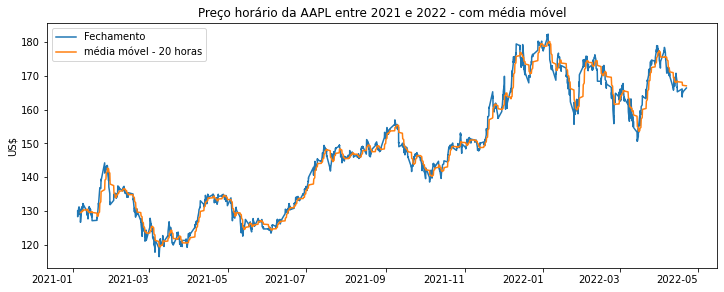

In [111]:
# plotando a variação de preço do ativo por hora
df_arima['Adj Close'].plot(figsize=(12,5), label=('Fechamento'))
df_arima['media_movel'].plot(label=('média móvel - 20 horas'))
plt.title('Preço horário da AAPL entre 2021 e 2022 - com média móvel')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)
plt.legend()

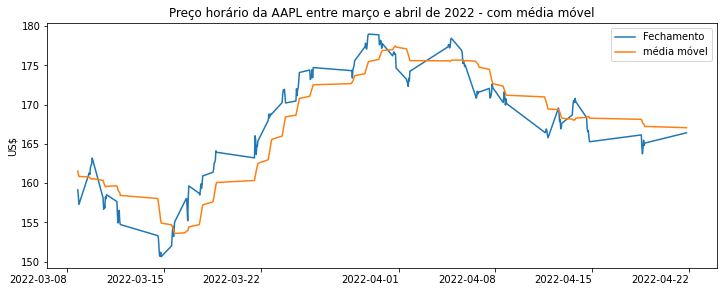

In [112]:
# plotando a variação de preço do ativo por hora - últimos 200 dados
df_arima['Adj Close'][-200:].plot(figsize=(12,5), label=('Fechamento'))
df_arima['media_movel'][-200:].plot(label=('média móvel'))
plt.title('Preço horário da AAPL entre março e abril de 2022 - com média móvel')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)
plt.legend()

### Identificando Outliers

Os outliers serão considerados através de 3 desvios padrão. Dessa forma, o primeiro passo é calcular o desvio padrão móvel. Para isso, vamos utilizar o método Rolling, como para a média móvel

In [114]:
# calculando desvio padrão móvel do dataset HORAS (janela de 20 horas)
df_arima['media_movel_d'] = df_arima['return_percent'].rolling(20).mean()
df_arima['std_movel_d'] = df_arima['return_percent'].rolling(20).std()

In [115]:
# identificando outliers

outliers_hora = []
upper_aapl = []
lower_aapl = []

# outliers no dataset de horas
for x, mm, sigma in list(zip(df_arima['return_percent'],df_arima['media_movel_d'],df_arima['std_movel_d'])):
  if (x > mm + 3*sigma) | (x < mm - 3*sigma):
    outliers_hora.append('outlier')
  else:
    outliers_hora.append('intlier')
  upper = mm + 3*sigma
  low = mm - 3*sigma
  upper_aapl.append(upper)
  lower_aapl.append(low)

df_arima['outliers'] = outliers_hora
df_arima['upper_limit'] = upper_aapl
df_arima['lower_limit'] = lower_aapl

In [116]:
# removendo dados nulos
df_arima.dropna(inplace=True)

CPU times: user 28.2 ms, sys: 0 ns, total: 28.2 ms
Wall time: 31.8 ms


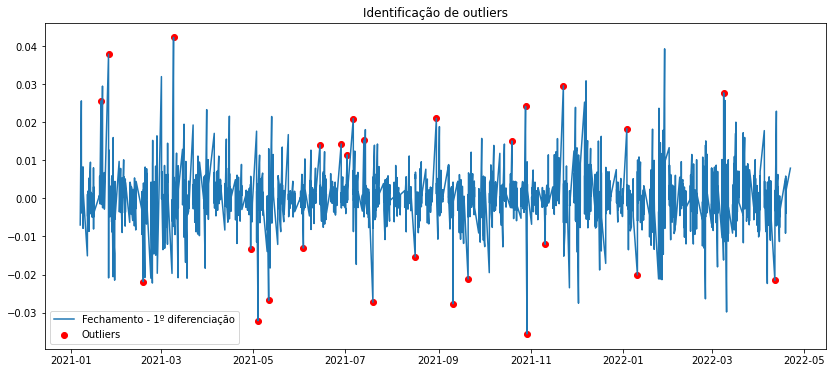

In [117]:
%%time

# plotando a variação de preço do ativo e os limites superior e inferior
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(df_arima['return_percent'], label = 'Fechamento - 1º diferenciação')
z = df_arima[df_arima['outliers']=='outlier']
ax.scatter(z.index, z['return_percent'], color = 'red', label = 'Outliers')

ax.set_title('Identificação de outliers')
ax.legend()

In [118]:
print('Quantidade de outliers AAPL HORA:', (df_arima['outliers']=='outlier').sum())

Quantidade de outliers AAPL HORA: 27


* Utilizando os dados de 20 horas anteriores para cálcula da média móvel e desvio padrão, temos 27 outliers

### Tratando outliers

Vamos utilizar o método de winsoring para eliminar os outliers

In [119]:
# criando feature de windoring - tratamento de outliers
df_arima['return_winso'] = stats.mstats.winsorize(df_arima['return_percent'],
                                                  limits=(0.01,0.01), axis=0)

In [120]:
df_arima.head()

,Open,High,Low,Close,Adj Close,Volume,return_percent,media_movel,media_movel_d,std_movel_d,outliers,upper_limit,lower_limit,return_winso
Date,,,,,,,,,,,,,,
2021-01-06 20:30:00+00:00,127.489899,127.589996,126.382004,126.589996,126.589996,19152815,-0.006982,129.497342,-0.001704,0.007616,intlier,0.021145,-0.024553,-0.006982
2021-01-07 14:30:00+00:00,128.360001,130.315002,127.919998,129.830093,129.830093,32013474,0.025595,129.494096,0.000018,0.009562,intlier,0.028704,-0.028667,0.019477
2021-01-07 15:30:00+00:00,129.839996,131.029999,129.690002,130.559998,130.559998,16316944,0.005622,129.609596,0.000933,0.009151,intlier,0.028385,-0.026520,0.005622
2021-01-07 16:30:00+00:00,130.570007,130.960007,129.850006,130.059998,130.059998,10993000,-0.003830,129.660606,0.000433,0.009123,intlier,0.027802,-0.026936,-0.003830
2021-01-07 17:30:00+00:00,130.070007,130.649994,130.020004,130.360001,130.360001,7367014,0.002307,129.730606,0.000579,0.009129,intlier,0.027966,-0.026807,0.002307


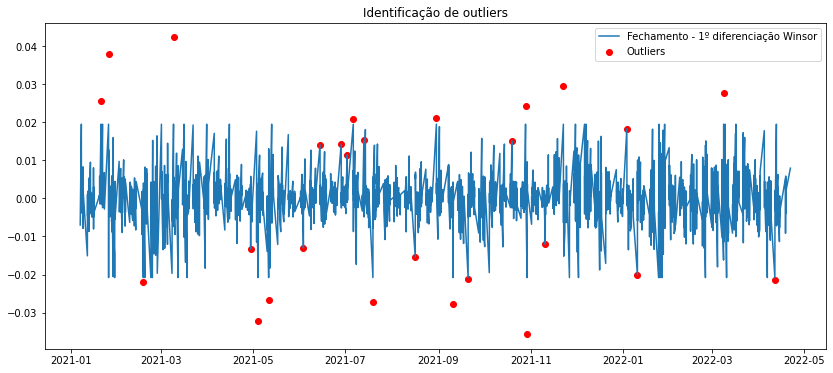

In [121]:
# plotando o return_winso
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(df_arima['return_winso'], label = 'Fechamento - 1º diferenciação Winsor')
z = df_arima[df_arima['outliers']=='outlier']
ax.scatter(z.index, z['return_percent'], color = 'red', label = 'Outliers')

ax.set_title('Identificação de outliers')
ax.legend()

* Nota-se que os dados ficaram mais "achatados", dentro dos limites definidos

## EDA para Variáveis Exógenas

Agora, vamos focar a EDA para os modelos de variáveis exógenas

In [145]:
# copiando o dataset
df_var_exog = df_aapl_hora.copy()

### Indicador RSI

O indicador RSI compara os ganhos recentes com as perdas recentes.

O valor varia de 0 a 100.



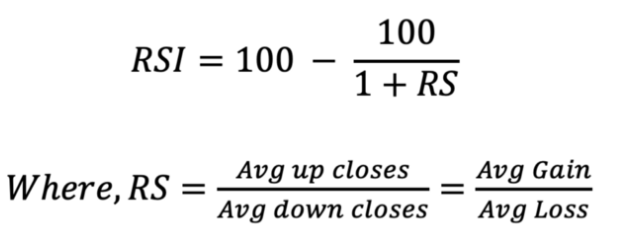

* RSI < 30 -> sinal de compra
* RSI > 70 -> sinal de venda

Podemos utilizar a lib talib para calcular os valores de RSI

In [146]:
RSI_PERIOD = 20 # definindo o período considerado para cálculo de RSI
df_var_exog['rsi'] = talib.RSI(df_var_exog['Adj Close'], RSI_PERIOD)  # criando a feature RSI

# RSI < 30 -> 0 (comprar)
# RSI > 70 -> 1 (vender)
# Else -> 2 (nada)

df_var_exog['rsi_indicator'] = df_var_exog['rsi'].apply(lambda x: 0 if x<30 else 1 if x>70 else 2) 
display(df_var_exog[['Adj Close','rsi','rsi_indicator']].tail(15))

,Adj Close,rsi,rsi_indicator
Date,,,
2022-04-14 13:30:00+00:00,168.470001,45.204134,2
2022-04-14 14:30:00+00:00,168.250000,44.551697,2
2022-04-14 15:30:00+00:00,166.960007,40.907501,2
2022-04-14 16:30:00+00:00,166.559998,39.843711,2
2022-04-14 17:30:00+00:00,166.669296,40.290312,2
2022-04-14 18:30:00+00:00,165.865005,38.099371,2
2022-04-14 19:30:00+00:00,165.279999,36.576523,2
2022-04-18 13:30:00+00:00,166.149994,40.311288,2
2022-04-18 14:30:00+00:00,164.630005,36.372305,2


In [147]:
# verificando quantidade de valores encontrados
df_var_exog['rsi_indicator'].value_counts()

2    2099
1     133
0      41
Name: rsi_indicator, dtype: int64

Text(0.5, 1.0, 'Variação de RSI entre 2021 e 2022 - indicação da faixa de compra e venda')

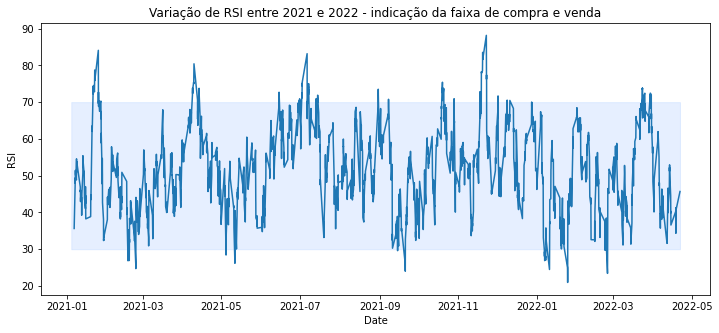

In [148]:
# plotando a variação de RSI
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_var_exog['rsi'].index, df_var_exog['rsi'], label='RSI')
ax.fill_between(df_var_exog['rsi'].index, y1=30, y2=70, color='#adccff', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('RSI')
ax.set_title('Variação de RSI entre 2021 e 2022 - indicação da faixa de compra e venda')

### Indicador de Bollinger Bands

O Indicador de Bollinger mostra a volatilidade do ativo.

Se %b > 1, é uma indicação de venda (1)
Se está < 0, então é sinal de compra (0)

In [149]:
# calculando a média móvel e limites superior e inferiror
# limites com base em 2 desvios padrão 
up, mid, low = BBANDS(df_var_exog['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# criando features para a média e os limites
df_var_exog['upper'] = up
df_var_exog['mid'] = mid
df_var_exog['low'] = low
df_var_exog['bbp'] = (df_var_exog['Adj Close'] - df_var_exog['low'])/(df_var_exog['upper'] - df_var_exog['low'])
df_var_exog.dropna(inplace=True)

Text(0.5, 1.0, 'Variação de do indicador de Bollinger - indicação da faixa de compra e venda')

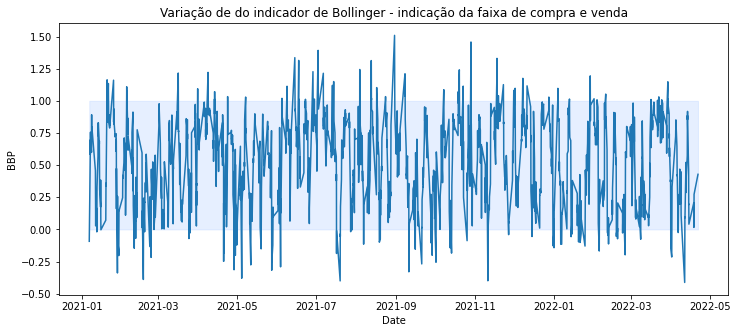

In [150]:
# plotando a variação de RSI
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_var_exog['bbp'].index, df_var_exog['bbp'], label='BBP (% Bollinger)')
ax.fill_between(df_var_exog['bbp'].index, y1=0, y2=1, color='#adccff', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('BBP')
ax.set_title('Variação de do indicador de Bollinger - indicação da faixa de compra e venda')

In [152]:
# sinais de compra e venda
# segundo indicador de Bollinger
print('Sinal de venda:',(df_var_exog['bbp']>1).sum())
print('Sinal de compra:',(df_var_exog['bbp']<0).sum())

Sinal de venda: 123
Sinal de compra: 137


## Conclusões da EDA

* Nossa série de Adj Close da AAPL horaria apresenta uma **série não estacionária**
* Como mostrado pelos dados agrupados mensalmente, **a série possui sazonalidade**
* **Há outliers na série** (outliers considerados com média móvel +/- 3*sigma móvel).
* Os outliers foram tratados com o **método de Windorize**
* **Com 1 diferenciação**, a série se tornou estacionária (parâmetro d=1 do ARIMA)
* Os **resíduos ficam maiores** no final do período analisado
* O indicador **RSI** indicou **41 sinais** de compra e **133 de venda**
* O indicador de **Bollinger** mostrou **137 sinais de compra** e 123 de venda